# EncoderDecoder

## Preliminaries

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/AN2DL/Homework2


### Import Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("TensorFlow version: ", tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

TensorFlow version:  2.15.0


##### TPU connection
In this way it is possibile to use also the tpu engine, which in our case compute faster than the gpu. Anyway, a gpu connection was required to save correctly the model. We did not investigate why.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = None


Not connected to a TPU runtime. Using CPU/GPU strategy


##### Define base paths

In [ ]:
base_path = 'networks/'
submission_file ='ToySubmission/'

### Import data

#### unzip data

In [ ]:
unzip = False
if unzip:
    !unzip data/training_dataset.zip

In [ ]:
delete = False
if delete:
  !rm data/categories.npy, data/training_data.npy, data/valid_periods.npy # Delete the unzipped dataset

#### Load the dataset

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)
data = np.load('data/training_data.npy', allow_pickle=True)

#### Categories

For each category, we keep the 277 timeseries with the longest valid periods. 277 is the number of timeseries in the smallest category.

In [ ]:
balanced_index = []
for i in np.unique(categories):

    indices_category = [index for index, category in enumerate(categories) if category == i]

    top_values_indices_category = sorted(indices_category, key=lambda idx: valid_periods[idx,0])[:277]

    for j in top_values_indices_category:
      balanced_index.append(j)
    del indices_category
    del top_values_indices_category
len(balanced_index)

data=data[balanced_index,:]
num_samples= data.shape[0]

#### Robust Scaling

As you can see it is not used since, in the way we implemented, it does not provide better performance

In [ ]:
robust = False
if robust is True:
  print(data.shape)

  # Find the index of the first non-zero element along the time axis (axis=1)
  non_zero_indices = np.argmax(data != 0, axis=1)

  # Extract the relevant portion of the time series data
  data_trimmed = np.array([data[i, index:] for i, index in enumerate(non_zero_indices)])
  print(data_trimmed.shape)
  # Flatten the array to a 2D array
  flattened_data = np.concatenate(data_trimmed)
  print(flattened_data.shape)

  # Remove NaN values from flattened_data
  flattened_data_without_nan = flattened_data[~np.isnan(flattened_data)]

  print("Flattened data without NaN:")
  print(flattened_data_without_nan.shape)

  # Compute the median of the flattened array
  Q1 = np.percentile(flattened_data_without_nan, 25, axis=0)
  Q3 = np.percentile(flattened_data_without_nan, 75, axis=0)
  IQR = Q3 - Q1
  normalized_data = (data_trimmed - Q1) / IQR
  print(normalized_data.shape)

  # Add zero-padding back to the beginning of each time series
  padded_data_again = []

  for i, index in enumerate(non_zero_indices):
      # Find the length of the removed portion (zero-padding)
      padding_length = index
      # Add zero-padding back to the beginning of each time series
      padded_row = np.pad(normalized_data[i], (padding_length, 0), 'constant', constant_values=(0, 0))
      padded_data_again.append(padded_row)

  data = np.array(padded_data_again)
  print("Padded data again shape:")
  print(data.shape)

(1662, 2776)
(1662,)
(906372,)
Flattened data without NaN:
(906372,)
(1662,)
Padded data again shape:
(1662, 2776)


#### Build Sequences

In [ ]:
data.shape, data.dtype

((1662, 2776), dtype('float64'))

In [ ]:
def build_sequences(df, window=200, stride=20, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    # temp_label = df.copy()
    padding_check = df.shape[1]%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - df.shape[1]%window
        padding = np.zeros((temp_df.shape[0],padding_len), dtype='float32')
        temp_df = np.concatenate((padding,temp_df),axis=-1)
        # padding = np.zeros((temp_label.shape[0],padding_len), dtype='float32')
        # temp_label = np.concatenate((padding,temp_label))
        assert temp_df.shape[1] % window == 0

    for temp_row in temp_df:
        for idx in np.arange(0,len(temp_row)-window-telescope,stride):
            dataset.append(temp_row[idx:idx+window])
            labels.append(temp_row[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
window, stride, telescope = 200, 10, 18
X_train, y_train = build_sequences(data, window, stride, telescope)

# X_train, y_train = data[:,:-18], data[:,-18:]

X_train = np.expand_dims(X_train, axis=-1)

print(X_train.shape, y_train.shape)

# Find indices where at least one value in each row is greater than zero
non_zero_rows_indices = np.where(np.any(X_train > 0, axis=(1)))[0]

# Filter X_train based on non-zero rows
X_train = X_train[non_zero_rows_indices]
y_train = y_train[non_zero_rows_indices]
print(X_train.shape, y_train.shape)

(430458, 200, 1) (430458, 18)
(88023, 200, 1) (88023, 18)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

input_shape, output_shape

((200, 1), 18)

### Build the Autoencoder

In [ ]:
latent_dim = 2048

In [ ]:
def get_encoder(enc_input_shape=input_shape, enc_output_shape=latent_dim, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')

    x = tfkl.Conv1D(32, 3, padding='same', use_bias=False)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(64, 3, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(128, 3, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling1D()(x)

    # x = tfkl.Conv1D(512, 3, padding='same', use_bias=False)(x)
    # x = tfkl.BatchNormalization()(x)
    # x = tfkl.LeakyReLU()(x)
    # x = tfkl.MaxPooling1D()(x)

    # Add a Bidirectional LSTM layer
    # x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)
    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    x = tfkl.Flatten()(x)
    output_layer = tfkl.Dense(enc_output_shape, name='output_layer', use_bias=False)(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')

    # Return the discriminator
    return model

if strategy is None: encoder = get_encoder(input_shape)
else:
  with strategy.scope(): encoder = get_encoder(input_shape)

encoder.summary()
# display(visualkeras.layered_view(encoder, legend=True, scale_xy=6))
# tfk.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 32)           96        
                                                                 
 batch_normalization_3 (Bat  (None, 200, 32)           128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 200, 32)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 100, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 64)           6144

In [ ]:
def get_decoder(dec_input_shape=latent_dim, dec_output_shape=output_shape, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')
    x = tfkl.Dense(8*256, use_bias=False)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Reshape((8,256))(x)

    x = tfkl.Conv1DTranspose(128, 3, padding='same', strides=2, use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    x = tfkl.Conv1DTranspose(64, 3, padding='same', strides=2, use_bias=False)(x)
    x = tfkl.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(5e-4), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
    # x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    x = tfkl.Conv1DTranspose(32, 3, padding='same', strides=2, use_bias=False)(x)
    x = tfkl.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(5e-4), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
    # x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # x = tfkl.Conv1DTranspose(64, 3, padding='same', strides=2, use_bias=False)(x)
    # x = tfkl.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(5e-4), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
    # # x = tfkl.BatchNormalization()(x)
    # x = tfkl.LeakyReLU()(x)

    # x = tfkl.Conv1DTranspose(32, 3, padding='same', strides=2, use_bias=False)(x)
    # x = tfkl.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(5e-4), kernel_initializer=tfk.initializers.HeUniform(seed))(x)
    # #x = tfkl.BatchNormalization()(x)
    # x = tfkl.LeakyReLU()(x)

    x = tfkl.Dropout(.1, seed=seed)(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')

    # Return the discriminator
    return model

if strategy != None:
   with strategy.scope(): decoder = get_decoder()
else: decoder = get_decoder()

decoder.summary()
# display(visualkeras.layered_view(decoder, legend=True, scale_xy=6))
# tfk.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 2048)              4194304   
                                                                 
 batch_normalization_7 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 8, 256)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 16, 128)           98304     
 anspose)                                                  

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 encoder (Functional)        (None, 2048)              13764576  
                                                                 
 decoder (Functional)        (None, 18, 1)             4527617   
                                                                 
 tf.compat.v1.squeeze (TFOp  (None, 18)                0         
 Lambda)                                                         
                                                                 
Total params: 18292193 (69.78 MB)
Trainable params: 18286881 (69.76 MB)
Non-trainable params: 5312 (20.75 KB)
_________________________________________________________________


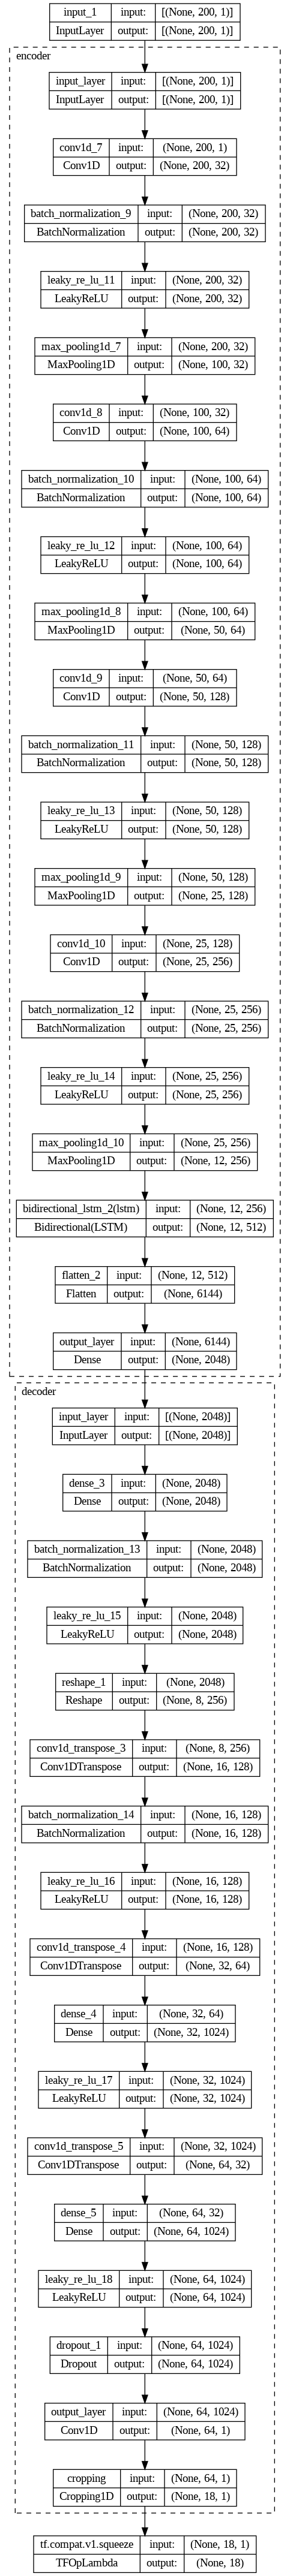

In [ ]:
def get_autoencoder(ae_input_shape=input_shape, ae_output_shape=input_shape):
    tf.random.set_seed(seed)

    encoder = get_encoder()
    decoder = get_decoder()

    input_layer = tfkl.Input(shape=ae_input_shape)

    # # Masking
    # input_layer = tfkl.Masking(mask_value=0.0, name='mask')(input_layer)

    z = encoder(input_layer)

    output_layer = decoder(z)

    model = tfk.Model(inputs=input_layer, outputs=tf.squeeze(output_layer, axis=-1), name='autoencoder')

    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())

    return model

if strategy is not None:
    with strategy.scope():
      autoencoder = get_autoencoder()
else: autoencoder = get_autoencoder()

autoencoder.summary()
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True)

#### Training

In [ ]:
batch_size = 200
epochs = 800

history = autoencoder.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.4,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, min_lr=5e-6),
    ]
).history

Epoch 1/800
265/265 [==============================] - 33s 58ms/step - loss: 5.6421 - val_loss: 2.9300 - lr: 0.0010
Epoch 2/800
265/265 [==============================] - 13s 51ms/step - loss: 1.5355 - val_loss: 0.9057 - lr: 0.0010
Epoch 3/800
265/265 [==============================] - 13s 51ms/step - loss: 0.5510 - val_loss: 0.3671 - lr: 0.0010
Epoch 4/800
265/265 [==============================] - 14s 51ms/step - loss: 0.2476 - val_loss: 0.1739 - lr: 0.0010
Epoch 5/800
265/265 [==============================] - 14s 52ms/step - loss: 0.1269 - val_loss: 0.1085 - lr: 0.0010
Epoch 6/800
265/265 [==============================] - 14s 52ms/step - loss: 0.0833 - val_loss: 0.0787 - lr: 0.0010
Epoch 7/800
265/265 [==============================] - 14s 52ms/step - loss: 0.0674 - val_loss: 0.0778 - lr: 0.0010
Epoch 8/800
265/265 [==============================] - 14s 52ms/step - loss: 0.0612 - val_loss: 0.0774 - lr: 0.0010
Epoch 9/800
265/265 [==============================] - 14s 53ms/step - l

0.04921156167984009

In [ ]:
0.04633287340402603

0.05015669763088226

0.04633287340402603


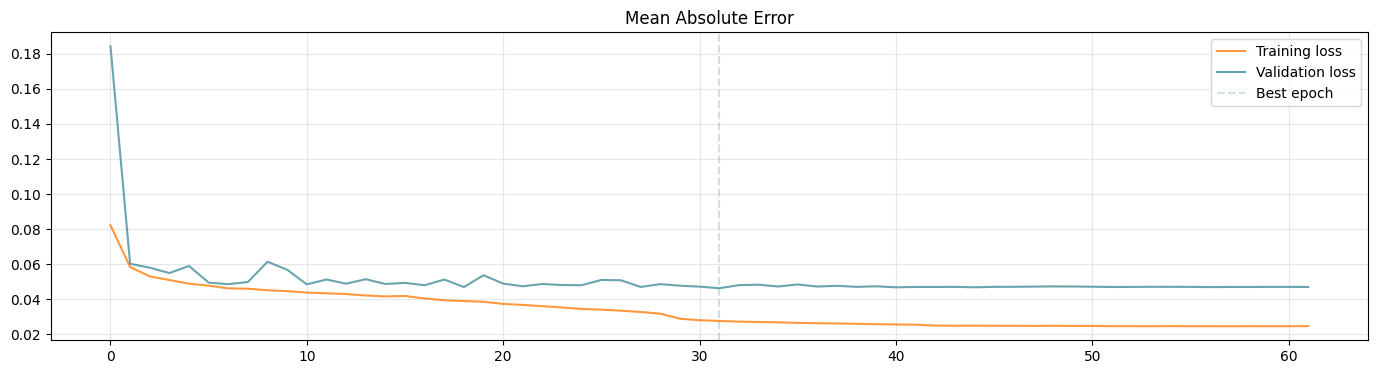

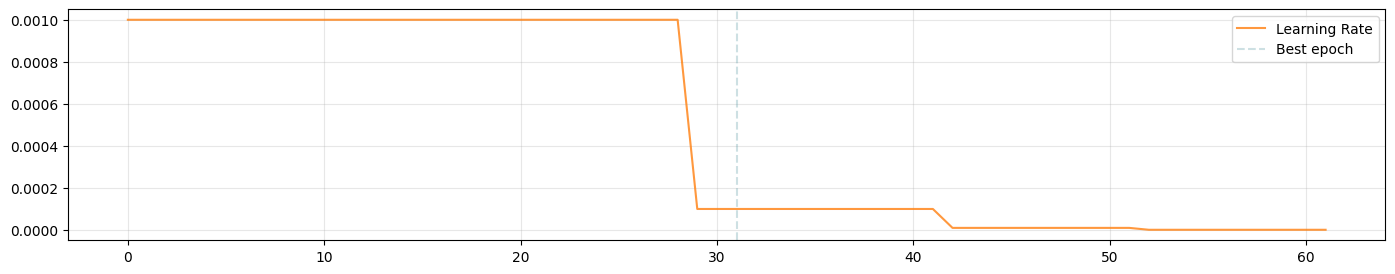

In [ ]:
print(np.min(history['val_loss']))

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
print(np.min(history['val_loss']))

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()


In [ ]:
model_name = 'EncoderDecoderLSTM_tele18_val4'

In [ ]:
saved_model_filepath = base_path + model_name

submission_model_filepath = submission_file + 'SubmissionModel'

In [ ]:
autoencoder.save(submission_model_filepath)

In [ ]:
# Export trained model
autoencoder.save(saved_model_filepath)